# Initial Synchronization for LTE

This notebook walks through the processing a received LTE signal from preliminary analysis through recovery of timing information and decoding of the cell ID.

<a href="https://colab.research.google.com/github/bepepa/giti_lectures/blob/master/LTE_synch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/giti_lectures/blob/main/LTE_synch.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# signal processing toolbox
from scipy import signal

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Load data and perform basic checks


In [2]:
# read the metadata file
import json

meta_file = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-meta'
data_file = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-data'

with open(meta_file) as f:
    meta_data = json.load(f)
    
meta_data

{'global': {'core:author': 'Daniel Estévez <daniel@destevez.net>',
  'core:datatype': 'ci16_le',
  'core:description': 'Recording of the LTE downlink signal of the Vodafone PCI 380 cell at Movistar Plus+ headquarters (10 MHz B20 channel)',
  'core:geolocation': {'coordinates': [-3.69678, 40.598363], 'type': 'Point'},
  'core:hw': 'USRP B205mini',
  'core:license': 'https://creativecommons.org/licenses/by/4.0/',
  'core:recorder': 'GNU Radio 3.9',
  'core:sample_rate': 30720000,
  'core:sha512': '0beac70c602caa65765bdbad8cafaf8ede7392106322a96188c4b3f48b4167ecc8e4e9414bf09af8058b9d8ce8919c413d570ef1e9d8c4d4507dfdc903ebf836',
  'core:version': '1.0.1'},
 'captures': [{'core:datetime': '2022-04-09T11:09:33.123597',
   'core:frequency': 806000000,
   'core:sample_start': 0}],
 'annotations': []}

From the meta-information, we see that the center frequency for the collect is 806MHz. 

This is the center frequency for the downlink of LTE band 20, which is used in the EU (Digital Dividend Band). It has an allocated bandwidth of 30MHz.

It is licensed for FDD use.

In [3]:
# Get the sample rate, carrier frequency, and the data type
Fs = meta_data['global']['core:sample_rate']
fc = meta_data['captures'][0]['core:frequency']
dtype = meta_data['global']['core:datatype']

In [4]:
# read the entire data file and convert to complex samples
tmp = np.fromfile(data_file, dtype=np.int16)

scale = 2.0**(-15)

rx = scale * tmp[0::2] + 1j * scale * tmp[1::2]

### Preliminary Signal Analysis

To verify the integrity of the signal, the power spectral density (PSD) and the spectrogram of the received signal is computed and plotted.

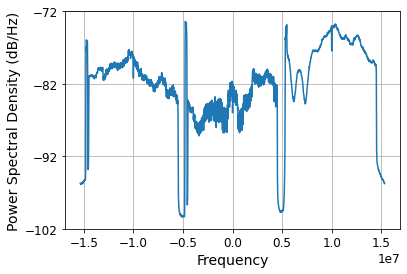

In [5]:
# First the PSD
Pxx, ff = plt.psd(rx[:], Fs=Fs, NFFT=2048)
# plt.xlim(-5e6, 5e6)
plt.show()

The PSD indicates that the received signal contains *three* signals of close to 10 MHz bandwidth each. There appear to be additional narrowband signals in the gaps between these signals - the origin and purpose of these signals is not clear. We will take a closer look at each of these signals below.

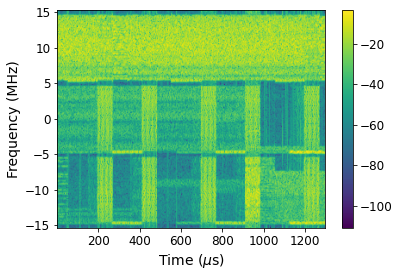

In [6]:
# For the spectrogram, we restrict the duration to about 1ms
# to reveal temporal structures
plt.specgram(rx[:40000], Fs=Fs/1e6)
plt.colorbar()
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Frequency (MHz)')
plt.show()

For an OFDM signal with $\Delta f=$ 15 KHz subcarrier spacing, each symbol is $T_s = \frac{1}{\Delta f}$ (approximately 70 $\mu s$) long. 

The two signals at the bottom of the spectrogram exhibit features that are consistent with this subcarrier spacing. Hence, we can conclude that they are likely OFDM signals.

The top signal does not exhibit a temporal structure; it is not clear that this is an OFDM signal.

The two signals at the bottom also appear to be symbol-synchronous.

For a closer examination of the three signals, we zoom in on each of the 10MHz bands, beginning with the band in the center.

A nominally 10 MHz wide LTE signal contains 50 resource blocks (RB), which in turn is made up of 12 subcarriers. Hence, the bandwidth of such a signal is $50 \cdot  12 \cdot 15 \text{ KHz} = 9.0 \text{ MHz}$. The red dashed lines in the plot below indicate the bandlimits of a 9 MHz bandwidth.

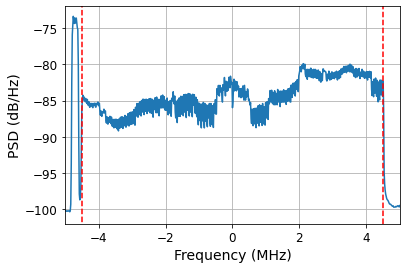

In [7]:
# PSD of center band
#plt.psd(rx[:], Fs=Fs, NFFT=2048)
plt.plot(ff/1e6, 10*np.log10(Pxx))
plt.plot([-4.5, -4.5], [-105, -72], 'r--')
plt.plot([4.5, 4.5], [-102, -72], 'r--')

plt.grid()

plt.xlim(-5, 5)
plt.ylim(-102, -72)

plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (MHz)')
plt.show()

The signal has a bandwidth of 9 MHz. 

The narrowband signal below -4.5MHz is clearly visible - it does not appear to be an OFDM signal. From the spectrogram, it does not appear to be synchronous with the OFDM symbols.

The "jagged" nature of the PSD is consistent with moduted subcarriers.

The center carrier appears to be suppressed; this is indicative of an LTE (not 5G) signal.

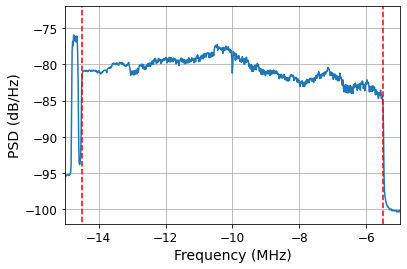

In [8]:
# PSD of lower band
#plt.psd(rx[:], Fs=Fs, NFFT=2048)
plt.plot(ff/1e6, 10*np.log10(Pxx))
plt.plot([-14.5, -14.5], [-105, -72], 'r--')
plt.plot([-5.5, -5.5], [-102, -72], 'r--')

plt.grid()

plt.xlim(-15, -5)
plt.ylim(-102, -72)

plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (MHz)')
plt.show()

The second PSD is very simlar in all respect to the signal in the center of the band.

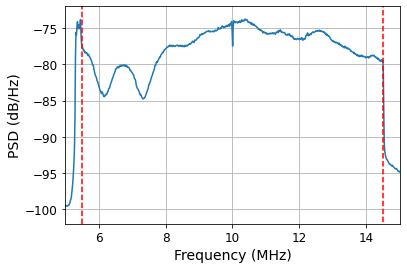

In [9]:
# PSD of upper band
#plt.psd(rx[:], Fs=Fs, NFFT=2048)
plt.plot(ff/1e6, 10*np.log10(Pxx))
plt.plot([14.5, 14.5], [-105, -72], 'r--')
plt.plot([5.5, 5.5], [-102, -72], 'r--')

plt.grid()

plt.xlim(5, 15)
plt.ylim(-102, -72)

plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (MHz)')
plt.show()

The signal in the upper band may also be an OFDM signal. If so, this band appears to be much more heavily loaded than the other two. 

Note: a brief attempt to process this signal has failed to detect the PSS.

### Signal Separation

We will separate the three signal using frequency translation (if needed) and low-pass filtering.

It may be possible to accomplish signal separation in the frequency domain (i.e., after taking the DFT, subcarriers outside the band of interest are suppressed).

However, it appears safer to remove (filter) signals outside the band of interest. Detection of the synchronization signal requires time-domain correlation which will be affected by the out-of-band signals.

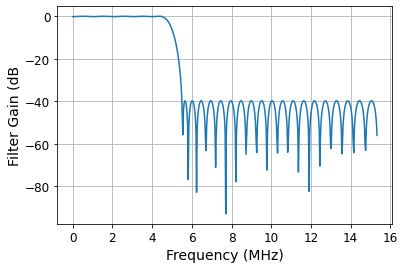

In [10]:
# design an FIR filter with (one-sided) bandwidth 4.5MHz
h = signal.remez(60, [0, 4.5e6, 5.5e6, Fs/2], [1, 0], fs=Fs)
w, H = signal.freqz(h, fs=Fs)

plt.plot(w/1e6, 20*np.log10(np.abs(H)))
plt.grid()

plt.xlabel('Frequency (MHz)')
plt.ylabel('Filter Gain (dB')

plt.show()

#### Filtering

We pass the received signal through the filter that we just designed. This will retain the center signal and reject the other two signals. The narrowband signal at the bandedge will be partially suppressed as it falls into the transition band of the filter.

To extract the other two signals, the signal must first be frequency shifted before it is filtered.

In [11]:
# filter the signal
fc = 0 # for lower band set to -10e6; for upper band, set to 10e6 (doesn't find PSS)
rxf = np.convolve(rx * np.exp(-2j * np.pi * fc * np.arange(len(rx)) / Fs), h)

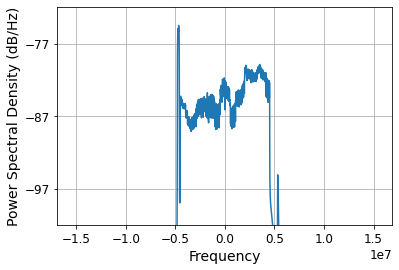

In [12]:
# verify that this worked - only the center signal should be visible
Pxx, ff = plt.psd(rxf, Fs=Fs, NFFT=2048)
plt.ylim(-102, -72)

plt.show()

## Timing Recovery

Now that we have isolated a single LTE band, we need to recover the timing of the LTE signal. 

Specifically, we want to identify the location of symbol boundaries and possibly even slot boundaries.

The primary synchronization signal (PSS) is intended for specifically this purpose. 

However, the PSS appear only once every 5ms (153600 samples). The search for the PSS is computationally expensive.

We can leverage the cyclic prefix (CP) that appears in every symbol to obtain an initial estimate of the symbol timing.

In [13]:
# system parameters
df_sc = 15e3
N_FFT = int(Fs / df_sc)
N_CP = 144

### Detecting the Cyclic Prefix

The cyclic prefix repeats the last $N_{CP}$ samples of an OFDM symbol before the start of the symbol.

Hence, we should see highly correlated samples separated by $N_{FFT}$ samples at the beginning of the cyclic prefix.

The code below computes this correlation for each sample instance $n$ over the first 10 OFDM symbol periods.

In [14]:
# compute the length-N_CP autocorrelation at lag N_FFT over time
N = 10*(N_FFT + N_CP)
corr = np.zeros(N, dtype=complex)

for n in range(N):
    seg1 = rxf[n : n+N_CP]
    m = n + N_FFT
    seg2 = rxf[m : m+N_CP]

    corr[n] = np.sum(seg2 * seg1.conj())

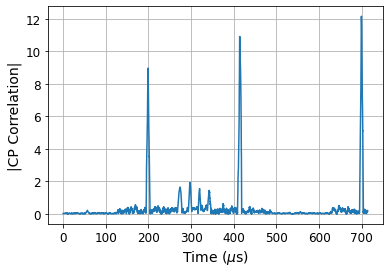

In [15]:
# plot the correlation
plt.plot(np.arange(N)/Fs*1e6, np.abs(corr))
plt.grid()

plt.xlabel('Time ($\mu$s)')
plt.ylabel('|CP Correlation|')

plt.show()

There are three prominent correlation peaks in the first 10 symbol periods.

Each of these correlation peaks indicates the location where the cyclic prefix of an OFDM symbol starts.

If the signal was fully occupied, then additional correlation peaks would be visible. However, several of the OFDM symbols appear to be empty or nearly empty.

The figure below shows that large correlation peaks coincide with the beginning of strong signal periods. 

Since the length of those strong signal periods are very close to the duration of an OFDM Symbol ($\approx 70 \mu s$), we can be reasonably sure that the correlation peaks indicate the start of symbol periods.

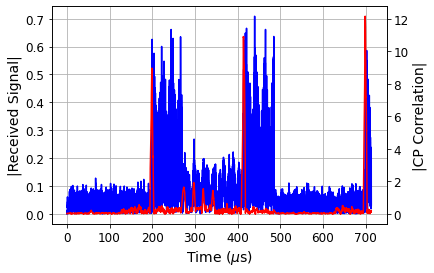

In [16]:
# plot the magnitude of the received signal over 10 symbol periods.
fig, ax = plt.subplots()
ax.plot(np.arange(N)/Fs*1e6, np.abs(rxf[:10*(N_FFT+N_CP)]), 'b-', label='Received')
plt.grid()

ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('|Received Signal|')

# super-impose the correlation plot
ax2 = ax.twinx()
ax2.plot(np.arange(N)/Fs*1e6, np.abs(corr), 'r-', label="Correlation")
ax2.set_ylabel('|CP Correlation|')

plt.show()

### Fine Estimation of correlation peaks

We find the exact location of the correlation peaks (by sample number).

Then, the frequency offset is estimated using the phase difference between the samples at the end of the symbol and the samples in the cyclic prefix, i.e., the pgase of the correlation at the peaks. 

In [17]:
## locate the three peaks by sample number
approx_locs = np.array([5000, 12000, 20000])
interval = 2000
true_locs = np.zeros_like(approx_locs)

for n in range(len(approx_locs)):
    a_loc = approx_locs[n]
    true_locs[n] = np.argmax(np.abs(corr[a_loc : a_loc+2000])) + a_loc

true_locs


array([ 6116, 12711, 21478])

In [18]:
df = np.zeros(len(true_locs))
for n in range(3):
    df[n] = np.angle(corr[true_locs[n]])/2048/2/np.pi*Fs
    print("location: {:d} - estimated frequency error: {:6.2f}".format(true_locs[n], df[n]))

location: 6116 - estimated frequency error: 1216.68
location: 12711 - estimated frequency error: 1261.99
location: 21478 - estimated frequency error: 1251.12


## OFDM Demodulation

With symbol boundaries and frequency offset, we are now at a point where we can demodulate the received signal. 

We begin by looking at the specifics of OFDM used by LTE from the standards document.

#### From TS 36.211: 

> **6.12 OFDM baseband signal generation**

> The time-continuous signal $s_l^{(p)}(t)$ on antenna port $p$ in OFDM symbol $l$ in a downlink slot is defined by
$$
s_l^{(p)}(t) = \sum_{k=-\lfloor N_{RB}^{DL}N_{sc}^{RB}/2 \rfloor}^{-1} a_{k^{(-)},l}^{(p)} \cdot \exp(j2\pi k \Delta f(t-N_{CP,l}T_s)) +
\sum_{k=1}^{\lceil N_{RB}^{DL}N_{sc}^{RB}/2 \rceil} a_{k^{(+)},l}^{(p)} \cdot \exp(j2\pi k \Delta f(t-N_{CP,l}T_s))
$$
> for $0 \leq t < (N_{CP,l} + N) \cdot T_s$ where $k^{(-)} = k+ \lfloor N_{RB}^{DL}N_{sc}^{RB}/2 \rfloor$ and $k^{(+)}=k+\lfloor N_{RB}^{DL}N_{sc}^{RB}/2 \rfloor -1$. The variable $N$ equals 2048 for $\Delta f = 15 \text{KHz}$.

This language implies that:
1. symbols are mapped to subcarriers in increasing order of frequency. Since most FFT libraries compute FFTs for normalized frequencies from 0 to 1, we must use `fftshift` fater taking the FFT of samples.
2. the subcarrier at zero frequency is left empty.
3. Depending on signal bandwidth, $N_{RB}^{DL} \cdot N_{sc}^{RB}$ are occupied. The number of subcarriers per resource block, $N_{sc}^{RB}$ equals 12 for $\Delta f = 15 \text{KHz}$. For the 10MHz signal on hand, $N_{RB}^{DL}$ equals 50.

The cyclic prefix is specified in the same section; for $\Delta f = 15 \text{KHz}$ the length of the cyclic prefix is 160 for slot number $l=0$ and it is 144 for slots $l=1,\ldots,6$.

According to section 6.2.1 Resource Grid of TS 36.211,
the quantity $N_{RB}^{DL}$ depends on the 
downlink transmission bandwidth configured in the cell and shall fulfil
$$
6 \leq N_{RB}^{DL} \leq 100.
$$ 
The set of allowed values for $N_{RB}^{DL}$ is given by 3GPP TS 36.104. They are $\{6, 15, 25, 75, 75, 100\}$.

The function below an be used to extract the information symbols from a received time domain signal for a given $N_{RB}^{DL}$. The signal is assumed to be frequency corrected before it is passed to this function.


In [19]:
def extract_OFDM(rx_samples, N_RB, N_sc_RB=12):
    """extract information symbols from samples
    
    Inputs:
    rx_samples - length N_FFT vector of received samples; these should be frequency corrected and start AFTER the cyclic prefix
    N_RB - number of resource blocks (BW)
    N_sc_RB - number of subcarriers per resource block (default: 12)

    Returns:
    length N_RB * N_sc_RB frequency domain symbols 
    
    """

    N_FFT = len(rx_samples)
    N_SC = N_RB * N_sc_RB

    # in the occupied BW there are N_SC+1 sub-carriers, N_SC on either side of DC
    # these are the indices of the subcarriers inside the occupied BW
    bw_sc = np.arange(N_FFT//2 - N_SC//2, N_FFT//2 + N_SC//2 + 1)

    # the DC carrier is empty in LTE
    # these N_SC indices skip the DC subcarrier
    active_sc = np.concatenate((np.arange(0, N_SC//2), np.arange(N_SC//2 + 1, N_SC + 1)))

    # FFT
    S = np.fft.fftshift( np.fft.fft( rx_samples ))

    S_bw = S[bw_sc]

    return S_bw[active_sc]

### Extract symbols from the slots with good correlations

With the function for extracting OFDM information symbols in hand, let us examine the contents of the three OFDM symbols with good correlations more closely.

For each of the three symbols, we will:
* apply frequency correction
* extract the information symbols
* plot the magnitude of information symbols (near the center of the band)

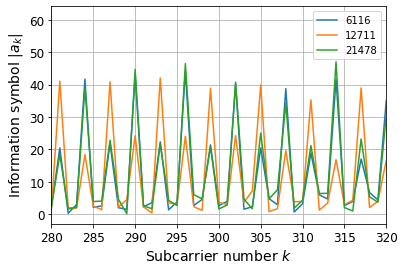

In [20]:
for n in range(len(true_locs)):
    start = true_locs[n] + N_CP # skip over the cyclic prefix

    # frequency correction
    sig = rxf[start:start+N_FFT] * np.exp(-2j*np.pi*df[n]*np.arange(N_FFT)/Fs)
    #FFT
    S = extract_OFDM(sig, 50)

    plt.plot(np.abs(S), label="{:d}".format(true_locs[n]))

plt.xlim(280,320)
plt.grid()

plt.xlabel('Subcarrier number $k$')
plt.ylabel('Information symbol $|a_k|$')
plt.legend()

plt.show()


The signals above are cell-specific reference signals (CRS). They are intended to train the frequency domain equalizer. They contain a known reference sequence (which depends on the cell ID).

CRS signals are specified in section 6.10.1 of TS 36.211. In systems that use multiple transmit antennas, different reference signals are transmitted on different antennas.

From the pattern above (and the fact that other symbols appear to be empty), we can conclude that this system has two transmit antennas. 

On each symbol that contains CRS, the reference signals occupy every sixth subcarrier; note that the spacing between similarly sized symbols is 6 subcarriers.

With two antennas, the two reference signals are interleaved: the first CRS occupies subcarriers 0, 6, 12, ... and the second CRS occupies subcarriers 3, 9, 15, ...

With two antennas, CRS appears on symbols 0 and 4 of every slot; except when the extended cyclic prefix is used, then CRS is on symbols 0 and 3. When more then two antennas are used, then slot 1 will also contain CRS.

### Insights from the CRS symbols

We already discussed that we can conclude that this system uses two transmit antennas.

We can also conclude that the system apears very lightly loaded as the only signals that yielded good correlations are the ones containing reference signals.

Finally, from the CRS pattern we can conclude where the slot boundaries are. 

Recall that CRS signals appear in symbols 0 and 4 of every slot. With slots containing seven symbols (with normal prefix length), the distance between two consecutive CRS frames is either 4 (from slot 0 to 4) or 3 (from slot 4 to 0).

We measure the starting locations for the CRS slots as 6,116, 12,711, and 21,478. Since the distance between the second and third CRS symbols is larger (than between first and second), we can conclude that our first complete slot starts at sample 12,711. n fact, if the location of the second peak is re-estimated using a cyclic prefix of 160 samples, then the estimated location is 12,694.

If this is all correct, then the difference between the location of the first and second CRS should be `3*(N_FFT+144)` and between the second and third it shold be `3*(N_FFT + 144) + 1*(N_FFT+160)`.

In [21]:
# check distances for correlation peaks
print("12694 - 6116 = {:d}; 3*(N_FFT + 144) = {:d}".format(12694 - 6116, 3*(N_FFT + 144)))
print("21478 - 12694 = {:d}; 3*(N_FFT + 144) + (N_FFT + 160)= {:d}".format(21478 - 12694, 3*(N_FFT + 144)+(N_FFT+160)))


12694 - 6116 = 6578; 3*(N_FFT + 144) = 6576
21478 - 12694 = 8784; 3*(N_FFT + 144) + (N_FFT + 160)= 8784


## Locating the Primary Synchronization Signal

The primary synchronization signal, together with the secondary synchronization signal (SSS), allows for precise localization of slot and symbol boundaries. It also facilitates accurate frequency error estimation.

The standards document TS 36.211 contains the following about the genration of the PSS:

> **6.11.1.1 Sequence generation**

> The sequence $d(n)$ used for the primary synchronization signal is generated from a frequency-domain Zadoff-Chu sequence according to
$$
d_u(n) = \begin{cases}
    \exp(-j\frac{\pi u n (n+1)}{63} & \text{ for $n=0,1, \ldots, 30$}\\
    \exp(-j\frac{\pi u (n+1)(n+2)}{63}) & \text{ for $n=31, 32, \ldots 61$}
\end{cases}
$$
> where the Zadoff-Chu root sequence index u is given by Table 6.11.1.1-1.

> **Table 6.11.1.1-1: Root indices for the primary synchronization signal**

<center>

| $N_{ID}^{(2)}$ | Root Index $u$ |
|:--------------:|:--------------:|
| 0              | 25             |
| 1              | 29             |
| 2              | 34             |

</center>

Note, the parameter $N_{ID}^{(2)}$ is part of the cell ID. Depending on which sequence (i.e., which $u$) is found, we obtain part of the cell ID.

The functions below generates the Zadoff-Chu sequence for a given root index $u$.

In [22]:
def fd_zadoff_chu(u):
    """Generate length-63 Zadoff-Chu sequence
    
    Input:
    u - root index

    Returns the length-63 Zadoff-Chu sequence (TS 36.211, section 6.11.1.1)

    Note: this sequence includes the null t the DC subcarrier. That also simplifies the formula
    for computing the sequence
    """
    n = np.arange(63)
    zc = np.exp(-1j*np.pi*u*n*(n+1)/63)
    zc[31] = 0  # This corresponds to the DC subcarrier
    
    return zc

#### Location of the PSS

The standard prescribes where the PSS must be located:

> **6.11.1.2 Mapping to resource elements**

> The mapping of the sequence to resource elements depends on the frame structure. The UE shall not assume that the primary synchronization signal is transmitted on the same antenna port as any of the downlink reference signals. The UE shall not assume that any transmission instance of the primary synchronization signal is transmitted on the same antenna port, or ports, used for any other transmission instance of the primary synchronization signal.

> The sequence $d(n)$ shall be mapped to the resource elements according to 
$$
a_{k,l} =d(n), n=0,\ldots,61 
$$
$$
k = n -31 + \frac{N_{RB}^{DL}N_{sc}^{RB}}{2}
$$


> For frame structure type 1, the primary synchronization signal shall be mapped to the last OFDM symbol in slots 0 and 10.

The mapping to subcarriers $k$ is reflected in the function below that generates the time-domain signal. 

In [23]:
def zadoff_chu(u, N_FFT):
    """Generate time-domain Zadoff-Chu sequence
    
    Input:
    u - root index
    N_FFT - FFT length

    Returns the length-(N_FFT+N_CP) time-domain Zadoff-Chu sequence 
    """
    # generate the FD sequence
    ZC = fd_zadoff_chu(u)

    # make a buffer for IFFT and insert ZC in the center
    buf = np.zeros(N_FFT, dtype=complex)
    buf[N_FFT//2 - 31 : N_FFT//2 + 32] = ZC

    # IFFT
    return np.fft.ifft(np.fft.ifftshift(buf))

Zadoff-Chu sequences are well suited for synchronization as they have good autocorrelation and cross-correlation properties.

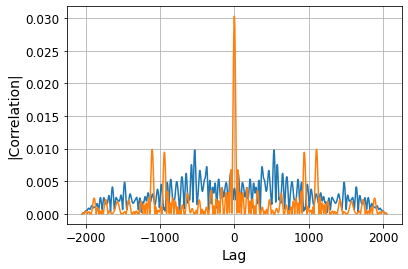

In [24]:
# check correlations for a couple of them
z1 = zadoff_chu(29, N_FFT)
z2 = zadoff_chu(34, N_FFT)

plt.plot(np.arange(-2047, 2048), np.abs(np.correlate(z1, z2, 'full')))
plt.plot(np.arange(-2047, 2048), np.abs(np.correlate(z1, z1, 'full')))

plt.grid()
plt.xlabel('Lag')
plt.ylabel('|Correlation|')

plt.show()


According to the standard, the PSS can only appear in the **last symbol of slots 0 and 10**. Since we were able to locate the slot boundaries, this greatly reduces the locations we must check.

At this time, we do not know the slot numbers. Hence, we must still look in every slot for the presence of the PSS. 

To locate the PSS, we perform the following steps, starting with the slot that we located starting at sample 12,694.
* locate the samples of the last symbol of the slot
* perform frequency offset correction
* correlate received samples agains each of the three ZC sequences
* check if any of them show significant correlation

In [25]:
## Locate the PSS
slot_start = 12694  # starting sample for first slot
delta_f = df[1]     # frequency offset
SEARCH_WIN = 10     # search a little before and after the estimated location

# Zadoff-Chu sequences
ROOT_INDICES = [25, 29, 34]
ZC = {n: {'u': ROOT_INDICES[n], 'sig': zadoff_chu(ROOT_INDICES[n], N_FFT)} for n in range(3)}
for n in range(3):
    ZC[n]['norm'] = np.linalg.norm(ZC[n]['sig']) # we'll use theseto normalize correlations

DONE = False

while not DONE:
    # locate the start of the last symbol
    sym_start = slot_start + 6 * (N_FFT + N_CP) + 16 # +16 because of longer prefix in symbol 0
    sym_start += N_CP  # skip over the preamble

    # extract the signal for this symbol
    sig = rxf[sym_start - SEARCH_WIN : sym_start + N_FFT + SEARCH_WIN]
    sig_norm = np.linalg.norm(sig[:N_FFT])

    # frequency correction
    sig = sig * np.exp(-2j*np.pi*delta_f*np.arange(len(sig))/Fs)

    # perform correlations between signal and all three ZC sequences
    max_corr = np.zeros(3)
    arg_max_corr = np.zeros(3, dtype=int)
    for n in range(3):
        corr = np.zeros(2*SEARCH_WIN+1)
        zc = ZC[n]['sig']
        zc_norm = ZC[n]['norm']
        for m in range(2*SEARCH_WIN+1):
            # search over search window
            corr[m] = np.abs(np.sum(sig[m:m+N_FFT] * np.conj(zc))) / (zc_norm * sig_norm)

        max_corr[n] = np.max(corr)
        arg_max_corr[n] = np.argmax(corr)

    # check correlation
    if np.max(max_corr) > 0.8:
        # found it!
        DONE = True
        N_id_2 = np.argmax(max_corr)

        print(
            "Found ZC sequence for N_ID_2 = {:d} in slot starting at {:d}; correlation: {:4.2f}, offset: {:d}".format(
                N_id_2,
                slot_start, 
                max_corr[N_id_2], 
                arg_max_corr[N_id_2] - SEARCH_WIN))
    else:
        # skip forward to next slot
        print("slot start: {:d}, max correlation: {:4.2f}".format(slot_start, np.max(max_corr)))
        slot_start += 7 * (N_FFT + N_CP) + 16


slot start: 12694, max correlation: 0.03
slot start: 28054, max correlation: 0.01
slot start: 43414, max correlation: 0.01
slot start: 58774, max correlation: 0.64
slot start: 74134, max correlation: 0.02
slot start: 89494, max correlation: 0.03
slot start: 104854, max correlation: 0.02
slot start: 120214, max correlation: 0.02
slot start: 135574, max correlation: 0.04
slot start: 150934, max correlation: 0.02
slot start: 166294, max correlation: 0.04
slot start: 181654, max correlation: 0.02
slot start: 197014, max correlation: 0.03
Found ZC sequence for N_ID_2 = 2 in slot starting at 212374; correlation: 0.86, offset: -1


So, we found a very good match. There appears to be a noisier match in an earlier slot (starting at sample 58,774) with correlation coefficient 0.64.

The offset indicates the position of the best match within the search window. The value -1, indicates that our initial timing estimate is very good. Based on the offset estimate, we should advance our estimates of the slot and symbol boundaries forward by one sample.

We plot the absolute values of the subcarriers for the symbol that carries the PSS below. The symbol appear to contain only the PSS.

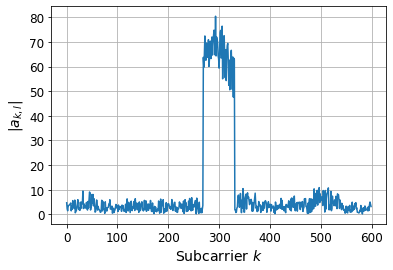

In [26]:
S = extract_OFDM(sig[9:2048+9], 50)
plt.plot(np.abs(S))
plt.grid()

plt.xlabel('Subcarrier $k$')
plt.ylabel('$|a_{k,l}|$')

plt.show()

### Refining the frequency offset estimate

In addition to confirming and refining our symbol timing estimate, we can also use the detected PSS for frequency offset estimation.

For that purpose, we measure the phase difference over the two halves of the received PSS multiplied by the conjugate of the ZC sequence, so that the phase of the ZC signal is stripped off.

We have two options for the received samples:
1. we can omit frequency correction prior to correlation; in that case, the frequency offset estimate measures the absolute frequency offset estimate.
2. we can apply frequency offset correction using our current estimate; then, the estimate indicates the residual frequency error - the absolute error is the sum of prior estimate and residual estimate.

Opion 2 is shown below.

In [27]:
## refine the frequency estimate
# grab the samples of the received signal
m = sym_start + arg_max_corr[N_id_2] - SEARCH_WIN
pss_start = m
sig = rxf[m : m+N_FFT] *  np.exp(-2j*np.pi*delta_f*np.arange(N_FFT)/Fs)
# and the correct ZC sequence
zc = ZC[N_id_2]['sig']

# multiply the two
sig_zc = sig * zc.conj()

# and sum each half seprately
pl = np.sum(sig_zc[:N_FFT//2])
pu = np.sum(sig_zc[N_FFT//2:])

# figure out the frequency offset
dfp = np.angle(pu*np.conj(pl))/(2*np.pi*N_FFT//2) * Fs + delta_f

print("Frequency offset estimate from PSS: {:6.2f}".format(dfp))
print("PSS starts at sample {:d}".format(pss_start))

Frequency offset estimate from PSS: 1149.78
PSS starts at sample 225685


## Secondary Synchronization Signal

The secondary synchronization signal (SSS) conveys two pieces of information:
1. it provides the remaining bits of the cell id $N_{ID}$, specifically it conveys $N_{ID}^{(1)}$ which takes on values between 0 and 167.
2. it resolves the remaining unertainty about symbol timing.

With respect to timing, recall that LTE signals are orgaized in frames of 10ms duration. 

Frames are divided into 10 subframes of 1ms duration each, these are numbered from 0 to 9.

Each subframe is divided into two slots of duration 0.5ms. Hence, there are 20 slots in each frame.

A PSS is located in the last OFDM symbol of slots 0 and 10. We cannot know if the PSS we detected was located in slot 0 or in slot 10. The SSS resolves this ambiguity ad therefore allows us to find the frame and subframe boundaries as well.

To convey the information about $N_{ID}^{(1)}$ and timing ambiguity, the SSS contains one of $2 \cdot 168 = 336$ possible sequences.

### Construction of the SSS

There are 336 possible SSS sequences that are constructed in a fairly complex process that involves that is spelled out in detail in section 6.11.2.1 of TS 36.211:

1. combinations and cyclic shifts of three different shift-register sequences (M-sequences)
2. the partial cell id $N_{ID}^{(1)}$ informs the cyclic shifts that are applied to these sequences
3. the combination of sequences is different for SSS in the first and second halves of the frame

We begin our construction with the three shift register sequences; these are denoted $\tilde{s}(n)$, $\tilde{c}(n)$, and $\tilde{z}(n)$ in the standard.

In [28]:
def tilde_s():
    "generate shift register sequence tilde_s from TS 36.211 section 6.11.2.1"
    x = np.zeros(31, dtype=np.uint8)
    
    # initial loading
    x[4] = 1

    # recursion
    for n in range(26):
        x[n+5] = (x[n+2] ^ x[n])

    return 1.0 - 2.0*x

In [29]:
def tilde_c():
    "generate shift register sequence tilde_c from TS 36.211 section 6.11.2.1"
    x = np.zeros(31, dtype=np.uint8)
    
    # initial loading
    x[4] = 1

    # recursion
    for n in range(26):
        x[n+5] = (x[n+3] ^ x[n]) 

    return 1.0 - 2.0*x

In [30]:
def tilde_z():
    "generate shift register sequence tilde_z from TS 36.211 section 6.11.2.1"
    x = np.zeros(31, dtype=np.uint8)
    
    # initial loading
    x[4] = 1

    # recursion
    for n in range(26):
        x[n+5] = (x[n+4] ^ x[n+2] ^ x[n+1] ^ x[n]) 

    return 1.0 - 2.0*x

The partial cell ID $N_{ID}^{(1)}$ is encoded in shifts of the above sequences via two intermediate variables $m_0$ and $m_1$. These variables are computed from $N_{ID}^{(1)}$ as follows (see section 6.11.2.1 in TS 36.211):
$$
\begin{align}
m_0 & = m^\prime \mod 31 \\
m_1 & = (m_0 + \lfloor m^\prime/31 \rfloor +1) \mod 31\\
m^\prime &= N_{ID}^{(1)} + q(q+1)/2 \\
q & = \left\lfloor \frac{N_{ID}^{(1)} + q^\prime(q^\prime+1)/2}{30} \right\rfloor \\
q^\prime &= \lfloor N_{ID}^{(1)}/30 \rfloor
\end{align}
$$

The function below computes $m_0$ and $m_1$ from $N_{ID}^{(1)}$.

In [31]:
def m_01(N_ID_1):
    "compute shifts m_0 and m_1 for given N_ID_1"
    q_prime = N_ID_1 // 30
    q = (N_ID_1 + (q_prime * (q_prime + 1)) // 2) // 30
    m_prime = N_ID_1 + (q * (q + 1)) // 2
    m_0 = m_prime % 31
    m_1 = (m_0 + m_prime // 31 + 1) % 31

    return (m_0, m_1)

In [32]:
## a few spot checks against Table 6.11.2.1-1 in TS 36.211
assert (0, 1, ) == m_01(0)
assert (29, 30, ) == m_01(29)
assert (0, 2, ) == m_01(30)
assert (2, 9) == m_01(167)

print("OK")


OK


The final step in the construction of the 336 possible sequences for the SSS is to combine cyclically shifted versions of the shift register sequences. 

The sequences are combined differently for SSS that appear in the first half of a frame (subframes 0 through 4) or the second half (subframes 5 through 9).

The standard specificies that the 62 frequency domain symbols that constitute the SSS are constructed as follows:

The even numbered elements of the SSS are given by:
$$
    d[2n] = \begin{cases}
    s_0^{(m_0)}(n) \cdot c_0(n) & \text{ in subframes $0,1,2,3,4$}\\
    s_1^{(m_1)}(n) \cdot c_0(n) & \text{ in subframes $5,6,7,8,9$}
    \end{cases}
$$

The odd-numbered elements of the SSS are given by:
$$
    d[2n+1] = \begin{cases}
    s_1^{(m_1)}(n) \cdot c_1(n) \cdot z_1^{m_0}& \text{ in subframes $0,1,2,3,4$}\\
    s_0^{(m_0)}(n) \cdot c_1(n) \cdot z_1^{m_1}& \text{ in subframes $5,6,7,8,9$}
    \end{cases}
$$

Above $s_i^{(m)}$, $c_i$, and $z_i^{(m)}$ are cyclic shifts of the shift register sequences $\tilde{s}$, $\tilde{c}$, and $\tilde{z}$, respectively. The code below provides specific details.

We can now generate the 336 SSS sequences. We store the sequences in a dictionary hat is keyed by an index $n$ computed as $n = N_{ID}^{(1)} + 168\cdot F$, where $F=0$ for the first half-frame and $F=1$ for the second half-frame.

In [33]:
## create a dictionary that contains all 336 SSS sequences
sss_d = {}

# compute the underlying m-sequences just once
tc = tilde_c()
ts = tilde_s()
tz = tilde_z()

# the sequences c0 and c1 don't depende on N_id_1
c0 = np.roll(tc, -N_id_2)
c1 = np.roll(tc, -(N_id_2+3))



for N_id_1 in range(168):
    # loop over N_id_1
    m0, m1 = m_01(N_id_1)
    s0_0 = np.roll(ts, -m0)
    s1_1 = np.roll(ts, -m1)
    z1_0 = np.roll(tz, -(m0 % 8))
    z1_1 = np.roll(tz, -(m1 % 8))

    for F in range(2):
        # loop for first and second half
        ind = N_id_1 + F*168

        d = np.zeros(62)
        if F == 0:
            # first half
            d[0::2] = s0_0 * c0
            d[1::2] = s1_1 * c1 * z1_0
        elif F == 1:
            # second half
            d[0::2] = s1_1 * c0
            d[1::2] = s0_0 * c1 * z1_1
        else:
            raise ValueError("invald value for F ({:d})".format(F))

        # store the sequence
        sss_d[ind] = {'N_id_1': N_id_1, 'F': F, 'seq': d}
    

### Matching the SSS

According to section 6.11.2.2 of TS 36.211, the SSS is located in the OFDM symbol that immediately precedes the PSS, i.e., in the second to last symbol of slot 0 and slot 10. Hence, after locating the SSS the samples for the PSS are easy to find.

For computational efficiency, it is much easier to correlate in the frequency domain, since the sequence length is only 62 - not 2048.

However, to perform matching in the frequency domain we must not only frequency correct the samples holding the SSS but also **equalize** the signal. Otherwise, the amplitude and phase distortion introduced by the channel corrupts the correlation.

Fortunately, euqalization is straightforward in OFDM. The following steps will be performed:
1. locate the samples that hold the two consecutive OFDM symbols for SSS and PSS; since we located the PSS accurately above, this is easily accomplished,
2. frequency correct both of these symbols using the frequency offset estimate from the PSS (variable `dfp`); performing frequency correction over both symbols ensures that the correction is continuous in phase,
3. estimate the frequency response of the channel from the PSS; this is as simple as multiplying the frequency domain PSS by the conjugate of the appropriate Zadoff-Chu sequence,
4. equalize the SSS via the estimated frequency response; this involves dividing the frequency domain samples by the estimated frequency response.

After these steps, we can perform matching in the frequency domain.

#### Extract and frequency correct  SSS and PSS symbols

We located the first sample of the PSS above (variable `pss_start`). From there, we can work backwards to find the first sample of the SSS.

From the start of the SSS, we can extract the samples for the OFDM symbols holding both PSS and SSS (excluding the CP of the SSS).

Finally, we perform frequency correction over these samples.

In [34]:
# find the start of the SSS
sss_start = pss_start - (N_FFT + N_CP)

# extract samples for SSS and PSS
N = 2*N_FFT + N_CP
ss_sig = rxf[sss_start : sss_start+N]

# frequency correct
ss_sig = ss_sig * np.exp(-2j * np.pi *dfp * np.arange(len(ss_sig)) / Fs)

# split the two signals, discard CP before PSS
sss_sig = ss_sig[:N_FFT]
pss_sig = ss_sig[-N_FFT:]

#### Channel Estimation using PSS

The final piece of information to be extracted from the PSS is an estimate of the frequency response of the channel. The frequency response is induced by the multi-path propagation of the signal.

The frequency response alters the magnitude and phase of the information symbols on each subcarrier.

We want to process the secondary synchronization signal SSS in the frequency domain. To do so, we must be able to remove the distortion from the channel's frequency response. This is called frequency domain equalization.

To estimate the frequency response of the channel, we:
1. transform the PSS signal to the frequency domain and extract the 62 subcarriers holding the Zadoff-Chu sequence,
2. muliply these 62 subcarriers by the conjugate of the Zadoff-Chu sequence for the $N_{ID}^{(2)}$ we determined ($N_{ID}^{(2)}=2$).

In [35]:
## channel estimation via PSS
pss_fd = extract_OFDM(pss_sig, 50) # all 600 subcarriers

# get the center 62 subcarriers
N_sc = 50 * 12
pss_fd = pss_fd[N_sc//2 - 31 : N_sc//2 + 31]

# multiply by conjugate of Zadoff-Chu sequence
zc = fd_zadoff_chu(ROOT_INDICES[N_id_2])
zc = np.concatenate( (zc[:31], zc[32:]) ) # strip out the zero in ZC sequence
H_est = pss_fd * np.conj( zc )

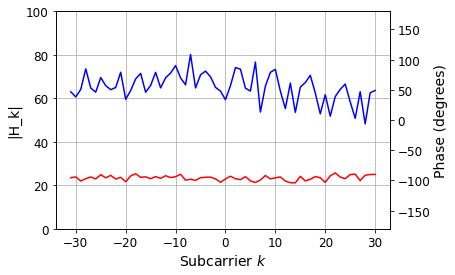

In [36]:
## plot the magnitude and phase of the channel estimate
fig, ax = plt.subplots()
# magnitude
ax.plot(np.arange(-31, 31), np.abs(H_est), 'b-', label='Magnitude')
plt.grid()

ax.set_xlabel('Subcarrier $k$')
ax.set_ylabel('|H_k|')
ax.set_ylim(0, 100)

# phase
ax2 = ax.twinx()
ax2.plot(np.arange(-31, 31), np.angle(H_est) * 180/np.pi, 'r-', label="Phase")
ax2.set_ylabel('Phase (degrees)')
ax2.set_ylim(-180, 180)

plt.show()

Both the magnitude and the phase are fairly constant over the bandwidth occupied by the PSS. This is indicative of very little multipath.

#### Equalize the SSS

We can now equalize the SSS in the frequency domain.

First, the subcarriers that contain the SSS must be extracted.

Then, these subcarriers aare divided by the estimated frequency response.

The resulting samples should show a BPSK constellation (modulation of the SSS).

In [37]:
## Equalize the SSS
sss_fd = extract_OFDM(sss_sig, 50) # all 600 subcarriers

# get the center 62 subcarriers
N_sc = 50 * 12
sss_fd = sss_fd[N_sc//2 - 31 : N_sc//2 + 31]

# equalize
sss_fd_eq = sss_fd / H_est

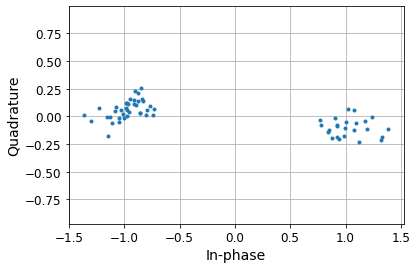

In [38]:
## plot the equalized SSS  symbols
plt.plot(sss_fd_eq.real, sss_fd_eq.imag, '.')
plt.grid()
plt.axis('equal')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')

plt.show()

The equalized samples show a very clean BPSK constellation. It should not be difficult to find the matching SSS sequence.

#### Find the matching SSS sequence

The final processing step for the SSS is to find which of the 336 possible SSS sequences matches the equalized frequency domain samples.

For that purpose, we correlate the equalized samples against each of the possible sequences and dtermine which one matches best.

In [39]:
corr = np.zeros(336)

for ind, d in sss_d.items():
    seq = d['seq']

    # correlation; only look at real part since we equalized
    corr[ind] = np.sum(sss_fd_eq.real * seq)

ind_max = np.argmax(corr)
N_id_1 = sss_d[ind_max]['N_id_1']
F = sss_d[ind_max]['F']

print("Best match for N_id_1 = {:d} in {:s} half-frame (correlation coefficient {:4.2f})".format( N_id_1,
'first' if F==0 else 'second',
corr[ind_max]/62))

Best match for N_id_1 = 126 in second half-frame (correlation coefficient 0.99)


#### Decoding the Phycal Cell ID (PCI)

The two partial cell IDs $N_{ID}^{(1)}$ and $N_{ID}^{(2)}$ must be combined to yield the phycal cell id (PCI) $N_{ID}^{cell}$. Section 6.11 of TS 36.211 states:

> **6.11 Synchronization Signals**

> There are 504 unique physical-layer cell identities. The physical-layer cell identities are grouped into 168 unique physical-layer cell-identity groups, each group containing three unique identities. The grouping is such that each physical-layer cell identity is part of one and only one physical-layer cell-identity group. A physical-layer cell identity
$N_{ID}^{cell} = 3N_{ID}^{(1)} + N_{ID}^{(2)}$ is thus uniquely defined by a number $N_{ID}^{(1)}$ in the range of 0 to 167, representing the physical-layer
cell-identity group, and a number $N_{ID}^{(2)}$ in the range of 0 to 2, representing the physical-layer identity within the
physical-layer cell-identity group.


We compute the PCI indicated by this signal and also compute the location of the next full frame (after the detected PSS) in the received samples.

In [40]:
print("PCI: {:d}".format(3*N_id_1 + N_id_2))
print("Next frame starts at or near sample {:d}".format(pss_start + (19-10*F) * Fs // 2000))

PCI: 380
Next frame starts at or near sample 363925


## Summary and Next Steps

We have shown how the timing structure of an LTE signal can be recovered from rceived samples. 

The cyclic prefix was leveraged to obtain initial estimates for the location of symbol boundaries and the frequency offset.

The estimated symbol boundaries were used to narrow the search space for the primary synchronization signal (PSS).

The PSS was located through correlation with three possible Zadoff-Chu sequences. This process yielded a refined estimate of symbol and slot timg, the partial cell ID $N_{ID}^{(2)}$, and a refined estimate of the frequency offset.

From the PSS, we located the secondary synchronization signal (SSS). From that signal, we extracted the remaining parts of the cell ID, $N_{ID}^{(1)}$, and determined that the slot containing the SSS was located in the second half of the frame. The latter information allows us to deduce frame boundaries. 

The next processing step is to extract and process the physical broadcast channel (PBCH). The resource elements for this channel are located in slot 1 of subframe 0 of every frame (i.e., it is transmitted every 10ms). The PBCH transmits the Master Information Block (MIB) which provides only very rudimentary information, including the system frame number, the down-link bandwidth, and the number of antennas.

## Differences in 5G

While the process to arrive at this point is similar in 5G, a number of differences exist.

The 5G signals still use SSS and PSS signals to establish timing and facilitate frequency correction. However, the sequences used by 5G are different (no Zadoff-Chu sequences). 

The signals PSS and SSS signals span 127 subcarriers, instead of 62. 5G does not exclude the DC carrier.

The PSS and SSS still provide information about the cell id. However, the number of PCI is greater n 5G, requiring more candidate sequences for the SSS.

The timing structure in 5G is fundamentally different  from LTE. This is largely a result of support for flexible subcarrier spacing (5G numerology).

The synchronization signals are generally not located in the center of the band. Instead, a raster of allowed center frequencies for the synchronization signals is defined to reduce the search space.